# Beat Tracking (Ellis) Implementation
This notebook illustrated the step-by-step implementation of Ellis 2007 beat tracking algorithm.

Note: The final callable implementation is in beat_tracker.py 
However, this notebook helps to show and visualize each step of the process.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
from scipy.signal import windows, convolve

import IPython.display as ipd


In [373]:
# filename = "BallroomData/Jive/Albums-Cafe_Paradiso-14.wav"
# filename = "BallroomData/ChaChaCha/Albums-Cafe_Paradiso-05.wav"
filename = "BallroomData/Quickstep/Albums-Ballroom_Classics4-20.wav"

In [374]:
snd, rate = librosa.load(filename, sr=None)
print(f"audio size: {snd.shape[0]}, sampling rate: {rate}")

audio size: 1401848, sampling rate: 44100


In [375]:
# Resample to 8kHz
snd_8k = librosa.resample(snd, orig_sr=rate, target_sr=8000)
print(f"audio size after resampling: {snd_8k.shape[0]}")

audio size after resampling: 254304


### Onset Strength

In [376]:
hop_time = 0.004
window_time=0.032
hop_length=round(8000*hop_time)
win_length=round(8000*window_time)

In [377]:
# # STFT (32ms window, 4ms hop size)
stft_mag = np.abs(librosa.stft(snd_8k, 
                        hop_length=hop_length, 
                        win_length=win_length
                        )
            )

# # Map to 40 Melbanks
melfb = librosa.filters.mel(sr=8000, n_fft=2048, n_mels=40)
mel = np.dot(melfb, stft_mag)

# # Mel spectrogram to dB
mel_db = librosa.amplitude_to_db(mel)


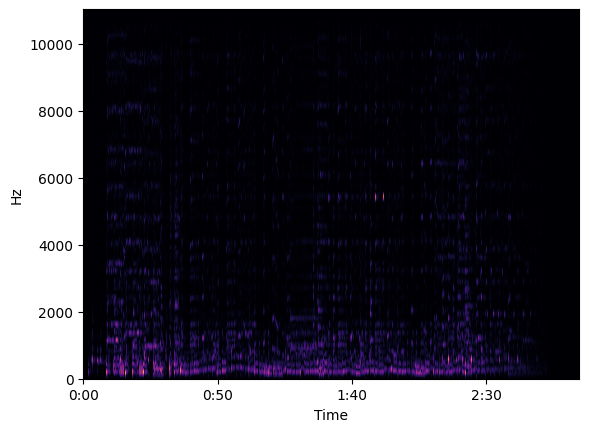

In [378]:
librosa.display.specshow(stft_mag, x_axis='time', y_axis='linear')

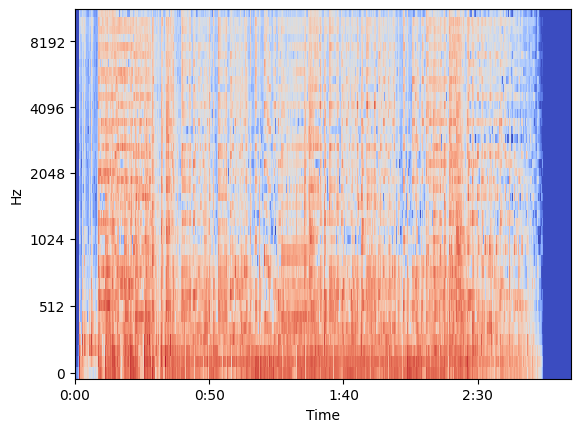

In [379]:
librosa.display.specshow(mel_db, y_axis='mel', x_axis='time')

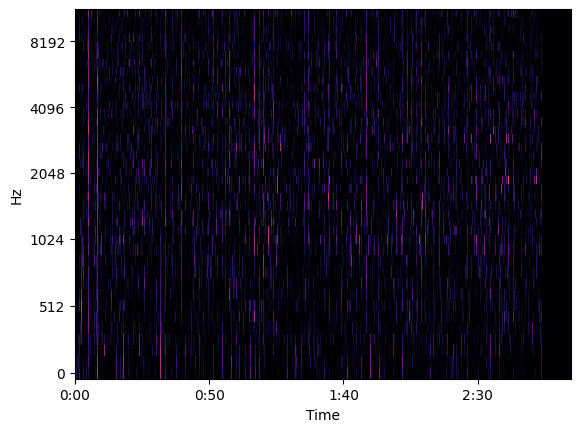

In [380]:
# apply first order diff
mel_db_delta = librosa.feature.delta(mel_db)
# half wave rect
mel_db_delta[mel_db_delta<0] = 0
librosa.display.specshow(mel_db_delta, x_axis='time', y_axis='mel')

In [381]:
# Sum across all freqency bands
freq_sum = mel_db_delta.sum(axis=0)

In [382]:
frame_rate = 8000/hop_length

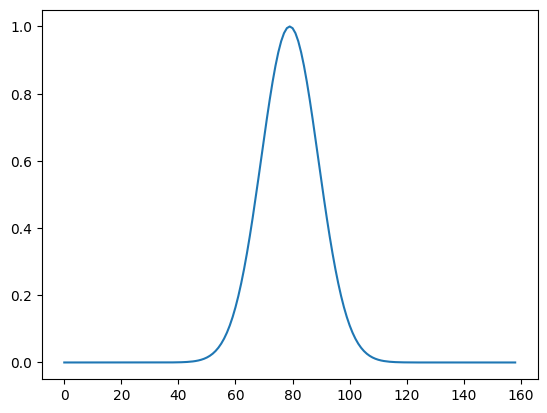

In [383]:
# Define gaussian window
gauss_size_t = 0.02
gauss_length = round(mel_db_delta.shape[1]*0.02)
gauss_std = 10
gauss_w = windows.gaussian(M=gauss_length, std=gauss_std)
plt.plot(gauss_w)

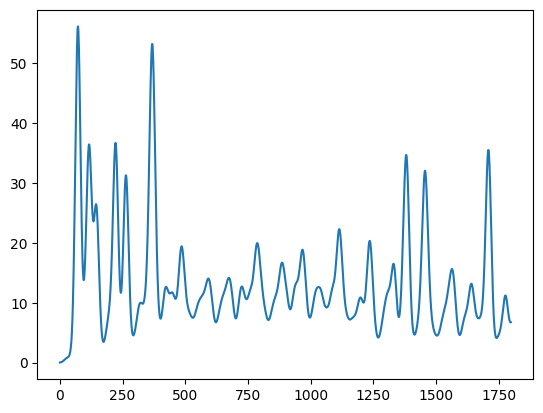

In [384]:
# Apply gaussian filter convolution
filtered = convolve(freq_sum, gauss_w, mode='same') / sum(gauss_w)
plt.plot(filtered[:1800])


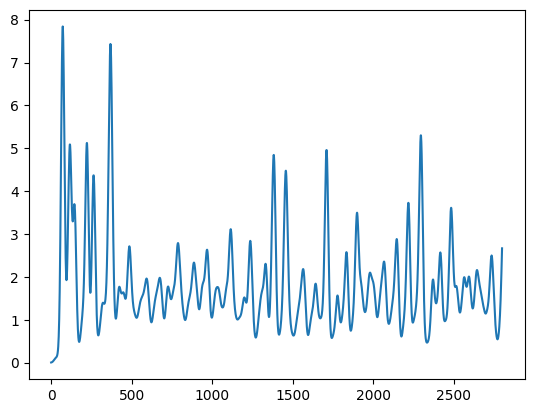

In [385]:
# Normalize by dividing over standard dev
filtered_norm = filtered/filtered.std()
plt.plot(filtered_norm[:2800])

In [386]:
filtered_norm.max()

7.840941179768126

### Tempo Estimation

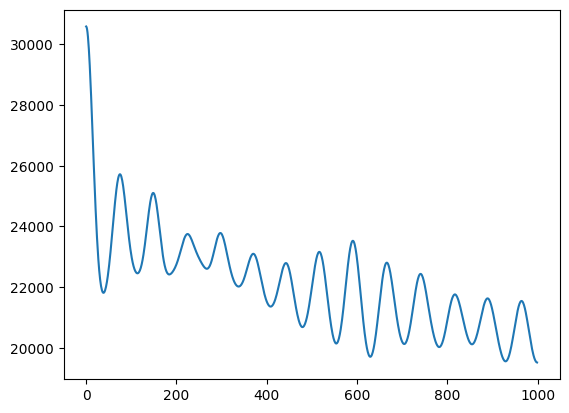

In [387]:
# Autocorrelate gaussian filtered signal
filtered_norm_corr = librosa.autocorrelate(filtered_norm)
plt.plot(filtered_norm_corr[:round(frame_rate*4)])

In [388]:
def tps(i):
    i_time = i/frame_rate
    val = filtered_norm_corr[i]
    w = np.exp(-0.5*((np.log2(i_time/0.5)/0.9)**2))
    return w*val

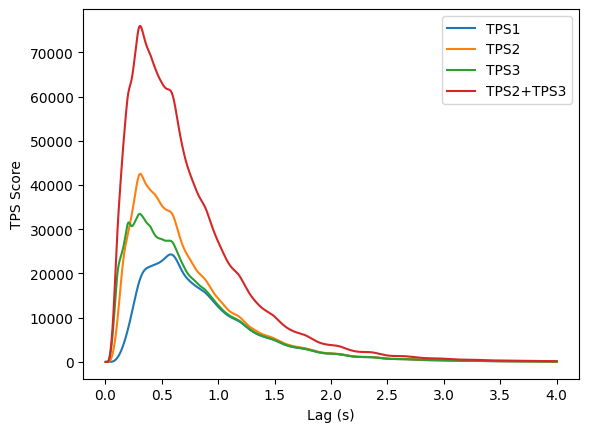

In [567]:
# Apply weighted gaussian onto autocorrelation signal
tps1 = filtered_norm_corr.copy()
tps2 = filtered_norm_corr.copy()
tps3 = filtered_norm_corr.copy()
for i, val in enumerate(filtered_norm_corr):
    if i ==0:
        tps1[i] = 0
        tps2[i] = 0
        tps3[i] = 0
    elif i >= 4*frame_rate:
        break
    else:
        tps1[i] = tps(i)
        tps2[i] = tps(i) + 0.5*tps(2*i) + 0.25*tps(2*i -1) + 0.25*tps(2*i + 1)
        tps3[i] = tps(i) + 0.33*tps(3*i) + 0.33*tps(3*i -1) + 0.33*tps(3*i + 1)

combined = tps2+tps3

x = [(i+1)/frame_rate for i in range(1000)]
plt.plot(x, tps1[:1000])
plt.plot(x, tps2[:1000])
plt.plot(x, tps3[:1000])
plt.plot(x, combined[:1000])

plt.xlabel("Lag (s)")
plt.ylabel("TPS Score")
plt.legend(["TPS1", "TPS2", "TPS3", "TPS2+TPS3"])

In [532]:
# Select frame with maximum value as estimated tempo
tempo_idx = tps1.argmax()
tempo = 60/(tempo_idx/frame_rate)
print(f"The estimated tempo is: {tempo} BPM")

tempo_idx = combined.argmax()
tempo = 60/(tempo_idx/frame_rate)
print(f"The estimated tempo (tps2 + tps3) is: {tempo} BPM")

The estimated tempo is: 104.16666666666667 BPM
The estimated tempo (tps2 + tps3) is: 197.3684210526316 BPM


In [420]:
# beats_file = "BallroomAnnotations-master/Albums-Cafe_Paradiso-14.beats"
# beats_file = "BallroomAnnotations-master/Albums-Cafe_Paradiso-05.beats"
beats_file = "BallroomAnnotations-master/Albums-Ballroom_Classics4-20.beats"


with open(beats_file) as my_file:
    testsite_array = my_file.readlines()
    ref_beats = np.array([float(val.split()[0]) for val in testsite_array])
    ref_beat_count = np.array([float(val.split()[1]) for val in testsite_array])

ref_beats_trimmed = mir_eval.beat.trim_beats(np.array(ref_beats), min_beat_time=5.0)
actual_tempo = 60/(ref_beats_trimmed[1:] - ref_beats_trimmed[:-1]).mean()

print(f"The actual tempo is: {tempo} BPM")

The actual tempo is: 197.3684210526316 BPM


In [429]:
ref_beats_trimmed

array([ 5.07,  5.34,  5.62,  5.9 ,  6.23,  6.54,  6.84,  7.12,  7.41,
        7.71,  8.  ,  8.29,  8.59,  8.89,  9.18,  9.49,  9.78, 10.07,
       10.37, 10.66, 10.95, 11.26, 11.54, 11.84, 12.14, 12.44, 12.74,
       13.04, 13.36, 13.64, 13.93, 14.2 , 14.51, 14.82, 15.12, 15.39,
       15.72, 16.  , 16.32, 16.61, 16.89, 17.19, 17.49, 17.78, 18.09,
       18.36, 18.68, 18.97, 19.26, 19.56, 19.87, 20.15, 20.46, 20.74,
       21.03, 21.32, 21.61, 21.91, 22.22, 22.51, 22.8 , 23.1 , 23.4 ,
       23.7 , 24.  , 24.3 , 24.58, 24.88, 25.17, 25.48, 25.77, 26.07,
       26.36, 26.66, 26.96, 27.25, 27.55, 27.83, 28.13, 28.42, 28.72,
       29.01, 29.32, 29.63, 29.92])

### Beat Tracking (DP)

In [392]:
period = (60/tempo) * frame_rate # samples per beat = num seconds between beats * frame_rate
period

76.0

In [393]:
# Based on matlab code from paper

def beatsimple(onset_env, period, alpha):
    # backlink(time) is best predecessor for this point
    # cumscore(time) is total cumulated score to this point
    backlink = np.zeros(len(onset_env))
    cumscore = onset_env.copy()

    # Search range for previous beat
    prev_range = range(int(np.round(-2*period)), int(-np.round(period/2)))

    # Log-gaussian window over that range
    txcost = (-alpha*abs((np.log(prev_range/-period))**2))

    print(f"Starting DP loop...")
    for i in range(-prev_range[-1], len(onset_env)):
        timerange = range(i + prev_range.start, i+prev_range.stop)

        # Search over all possible predecessors and apply transition weighting
        scorecands = txcost + cumscore[timerange]
        # Find best predecessor beat
        max_val = scorecands.max()
        max_idx = scorecands.argmax()
        
        # Add on local score
        cumscore[i] = max_val + onset_env[i]
        # Store backtrace
        backlink[i] = timerange[max_idx]
        
    print(f"Starting backtrace...")
    # Start backtrace from best cumulated score
    beat_idx = cumscore.argmax()
    beats = []
    beat_idxs = []

    # then find all its predecessors
    while backlink[beat_idx] > 0:
        beats.append(beat_idx/frame_rate)
        beat_idxs.append(beat_idx)
        beat_idx = int(backlink[beat_idx])
        
    return beats, beat_idxs

In [394]:
# beats, beat_idxs = beatsimple(filtered_norm, period=np.float64(125), alpha=680)
beats, beat_idxs = beatsimple(filtered_norm, period=period, alpha=680)

Starting DP loop...
Starting backtrace...


In [395]:
len(beats)

100

### Down Beat Detection

In [517]:
# Identify source of truth downbeats
ref_down_beats = ref_beats[ref_beat_count==1]

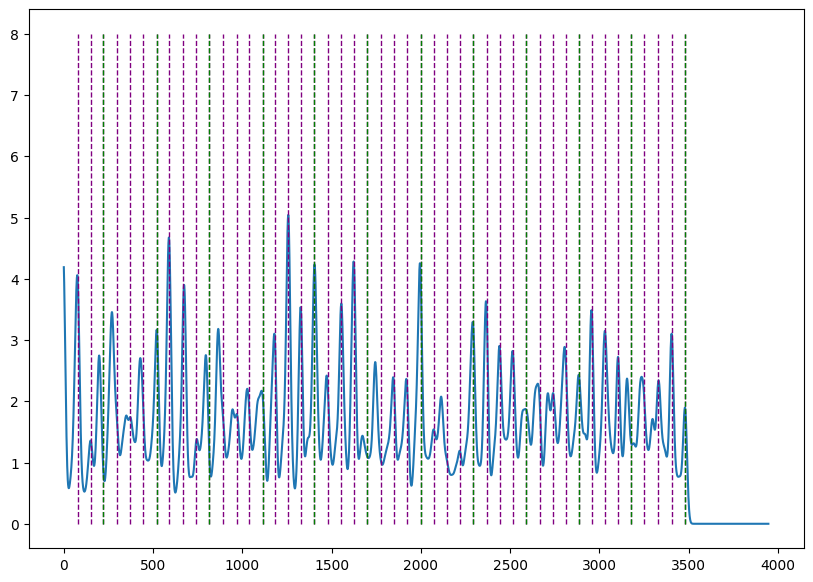

In [518]:
# Plot downbeats against onset strength envelope
onset_strength_plt = filtered_norm[4000:]
ref_beats_plt = np.round(ref_beats_trimmed*frame_rate)-4000
ref_down_beats_plt = np.round(ref_down_beats*frame_rate)-4000

plt.figure(figsize=(10, 7))
plt.plot(onset_strength_plt)
plt.vlines(x=ref_beats_plt[ref_beats_plt>0], ymin=0, ymax=8, colors='purple', ls='--', lw=1, label='beats')
plt.vlines(x=ref_down_beats_plt[ref_down_beats_plt>0], ymin=0, ymax=8, colors='green', ls='--', lw=1, label='down beats')



In [519]:
# Trim downbeat indices to remove first 5 seconds
beat_idxs_trimmed = np.array(beat_idxs)[np.array(beat_idxs) >= 1250]
beat_onset_strength = filtered_norm[beat_idxs_trimmed]

In [525]:
# Get sum of onset strength for each possbile set of downbeats
metric_strength = []
metric = 4
for i in range(metric):
    metric_strength.append(beat_onset_strength[i::metric].sum())

In [526]:
# Get set of beats with highest total onset strength
metric_strength_max_idx = np.array(metric_strength).argmax()
downbeat_idxs = beat_idxs_trimmed[metric_strength_max_idx::metric]

In [527]:
downbeats = downbeat_idxs/frame_rate

In [528]:
downbeats

array([29.336, 28.136, 26.94 , 25.756, 24.572, 23.388, 22.204, 21.02 ,
       19.836, 18.652, 17.464, 16.28 , 15.088, 13.904, 12.72 , 11.532,
       10.348,  9.156,  7.944,  6.728,  5.508])

In [524]:
ref_down_beats

array([ 0.3 ,  1.48,  2.7 ,  3.86,  5.07,  6.23,  7.41,  8.59,  9.78,
       10.95, 12.14, 13.36, 14.51, 15.72, 16.89, 18.09, 19.26, 20.46,
       21.61, 22.8 , 24.  , 25.17, 26.36, 27.55, 28.72, 29.92])

### Evaluation

In [33]:
import mir_eval

In [396]:
beats_trimmed = mir_eval.beat.trim_beats(np.array(beats), min_beat_time=5.0)

In [403]:
mir_eval.beat.validate(ref_beats_trimmed, np.flip(beats_trimmed))


In [404]:
mir_eval.beat.f_measure(ref_beats_trimmed[1:], np.flip(beats_trimmed), f_measure_threshold=0.07)

0.8994082840236687

In [405]:
mir_eval.beat.cemgil(ref_beats_trimmed, np.flip(beats_trimmed))

(0.7730132745338721, 0.7730132745338721)

In [406]:
mir_eval.beat.goto(ref_beats_trimmed, np.flip(beats_trimmed))

1.0

In [407]:
mir_eval.beat.continuity(ref_beats_trimmed, np.flip(beats_trimmed))

(0.8705882352941177,
 0.8705882352941177,
 0.8705882352941177,
 0.8705882352941177)